## Entrenamiento de ResNet50 con data augmentation y 3 modelos

Se procede al particionado de datos de train y valid por separado para aplicar data augmentation en entrenamiento mediante la librería imgaug. Luego, se proceden a realizar un modelo de clasificación binaria para discriminar primero el tipo de enfermedad, y posteriormente, se creará un modelo específico para enfermedades cancerígenas y no cancerígenas.

Comenzamos por la importación de librerías

In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '20'

import albumentations
# Librerías utilizadas por el script
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from fastai.vision.all import *
from fastai.callback.all import *
from sklearn.utils import class_weight


from sklearn.model_selection import train_test_split
import torch.utils.mobile_optimizer as mobile_optimizer
from torch.utils.mobile_optimizer import optimize_for_mobile
from torch.utils.data.sampler import WeightedRandomSampler


print("Selected: ", torch.cuda.get_device_properties(torch.cuda.current_device()).name)

Selected:  NVIDIA GeForce RTX 3080


In [2]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

A continuación, se declaran las constantes usadas como parámetros a las funciones

In [3]:
# Número de clases. 2 para la binaria.
NUM_CLASSES = 2
TRAIN_DIR = "trainThumbnails/"
SEED = 26
set_seed(SEED)
# Número de canales de cada imagen
CHANNELS = 3
IMAGE_RESIZE = 396
VALID_PCT = 0.3
RESIZE_METHOD = 'squish'
METRICS = [accuracy, BalancedAccuracy(), error_rate, Recall(), Precision()]

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 100
FREEZE_EPOCHS = 70

EARLY_STOP_PATIENCE = 3

BATCH_SIZE = 32

np.random.seed(SEED)

Realizamos la seperación de entrenamiento y validación, junto el aumento de datos. Primero, se separa el entrenamiento para evitar un sesgo de los resultados en validación, y posteriormente, se procede a la construcción de los dataframes.

In [4]:
train_df = pd.read_csv('trainSet.csv')
display(train_df)

,Unnamed: 0,image,dir,label,dataset,bin
0,0,ASAN_8196.png,datasets/Asan/dataset/hemangioma/ASAN_8196.png,hemangioma,ASAN,Benign
1,1,ASAN_10059.png,datasets/Asan/dataset/dermatofibroma/ASAN_10059.png,dermatofibroma,ASAN,Benign
2,2,SEV_248_74.png,datasets/Severance/thumbnails/SEV_248_74.png,pyogenic_granuloma,SEVERANCE,Benign
3,3,ISIC_0068761.JPG,datasets/ISIC/Melanoma/ISIC_0068761.JPG,melanoma,ISIC,Malignant
4,4,SEV_062_17.png,datasets/Severance/thumbnails/SEV_062_17.png,squamous_cell_carcinoma,SEVERANCE,Malignant
...,...,...,...,...,...,...
64876,64876,ISIC_0014898.JPG,datasets/ISIC/Nevus/ISIC_0014898.JPG,nevus,ISIC,Benign
64877,64877,SEV_345_42.png,datasets/Severance/thumbnails/SEV_345_42.png,syringoma,SEVERANCE,Benign
64878,64878,ISIC_0062505.JPG,datasets/ISIC/Melanoma/ISIC_0062505.JPG,melanoma,ISIC,Malignant
64879,64879,SEV_164_8.png,datasets/Severance/thumbnails/SEV_164_8.png,hemangioma,SEVERANCE,Benign


bin
Benign       35664
Malignant     9752
Name: count, dtype: int64


<Axes: xlabel='bin', ylabel='count'>

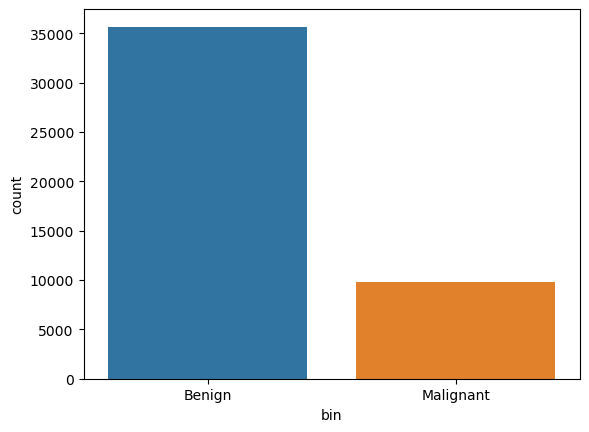

In [5]:
# Separación validación y train

train, valid = train_test_split(train_df, test_size=VALID_PCT, stratify=train_df[['bin']])

# Vemos cómo es el desequilibrio entre clases
print(train.bin.value_counts())

sns.countplot(data=train, x='bin', order=train_df.bin.value_counts().index)



In [6]:
 # Hallamos cuál es la proporción entre las dos clases para igualarlas mediante aumento de datos
benign_count, malign_count = train.bin.value_counts()
print("MAL/BENG: ", benign_count / malign_count)

MAL/BENG:  3.657095980311731


Podemos generar hasta 3 imágenes por data augmentation de la clase maligna para equiparar aproximadamente ambas clases

In [7]:
def binary_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname).split("/")[1]]
    return el['bin'].values[0]

In [8]:
def get_train_aug():
    return albumentations.Compose([
        albumentations.Transpose(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
        albumentations.OneOf([
            albumentations.MotionBlur(blur_limit=5),
            albumentations.MedianBlur(blur_limit=5),
            albumentations.GaussNoise(var_limit=(5.0, 30.0)),
        ], p=0.7),

        albumentations.OneOf([
            albumentations.OpticalDistortion(distort_limit=1.0),
            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
            albumentations.ElasticTransform(alpha=3),
        ], p=0.7),

        albumentations.CLAHE(clip_limit=4.0, p=0.7),
        albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        albumentations.Resize(IMAGE_RESIZE, IMAGE_RESIZE),
        #albumentations.Normalize()
    ])


def get_valid_aug():
    return albumentations.Compose([
        albumentations.Resize(IMAGE_RESIZE, IMAGE_RESIZE),
        #albumentations.Normalize()
    ])


In [9]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()

    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [10]:
item_tfms = [Resize(IMAGE_RESIZE), AlbumentationsTransform(get_train_aug())]

In [11]:
train_ds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el metodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=VALID_PCT, seed=SEED),
    get_y=binary_label,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=item_tfms,  # Redimensionado
    batch_tfms=Normalize.from_stats(*imagenet_stats)
).dataloaders(TRAIN_DIR, bs=BATCH_SIZE)

In [12]:

class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(train_df['bin'].to_list()),
                                                 y = train_df['bin'].to_list())

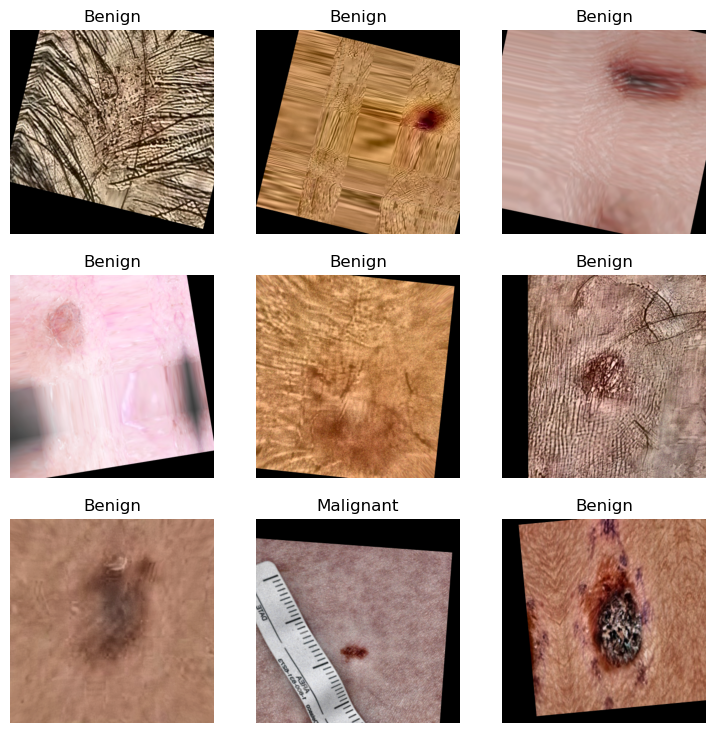

In [13]:
train_ds.train.show_batch()

In [14]:
learn_resnet = vision_learner(train_ds, models.resnet50, loss_func=CrossEntropyLossFlat(weight=torch.FloatTensor(class_weights).cuda()), metrics=METRICS, pretrained=True)
print(learn_resnet.summary())

Sequential (Input shape: 32 x 3 x 396 x 396)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 198 x 198 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 99 x 99   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 99 x 99  
Conv2d                                    16384      False     
BatchNorm2d                        

In [15]:
train_ds.vocab
print(class_weights)

[0.63672496 2.32848837]


/home/cristhian/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


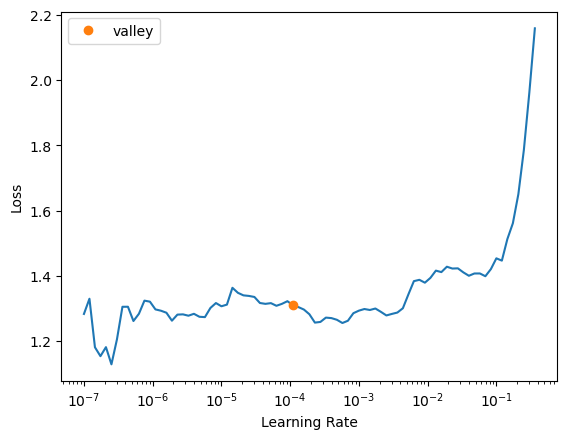

In [16]:
lrs = learn_resnet.lr_find()

# Creamos callbacks para el modelo
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=EARLY_STOP_PATIENCE)
save_callback = SaveModelCallback(monitor='valid_loss', fname='best_model_augmented_freeze32')
callbacks = [early_stopping, save_callback, ShowGraphCallback]

In [17]:
lr_mult = 100
base_lr = lrs[0] / 2
print("ENTRENAMIENTO: Finetuning")
print("=========================\n Fase de congelado:")
print(f" LR: {lrs[0]}")

ENTRENAMIENTO: Finetuning
 Fase de congelado:
 LR: 0.00010964782268274575


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,1.030667,0.703092,0.601161,0.673693,0.398839,0.800719,0.325384,06:47
1,0.987030,0.656482,0.643701,0.703818,0.356299,0.809102,0.354981,06:49
2,0.954585,0.651080,0.639591,0.706861,0.360409,0.824671,0.354000,06:48
3,0.889718,0.627436,0.653822,0.718096,0.346178,0.830659,0.365091,06:48
4,0.865274,0.595519,0.691790,0.726680,0.308210,0.787784,0.391454,06:20
5,0.848996,0.586581,0.680693,0.731282,0.319307,0.819880,0.385213,06:00
6,0.845020,0.571111,0.706535,0.737459,0.293465,0.791617,0.405671,05:59
7,0.827539,0.555769,0.711210,0.744962,0.288790,0.804072,0.411397,05:59
8,0.818287,0.547587,0.705610,0.743835,0.294390,0.810778,0.406607,06:01
9,0.796639,0.541581,0.736539,0.746633,0.263461,0.764311,0.435037,06:01


Better model found at epoch 0 with valid_loss value: 0.7030916213989258.


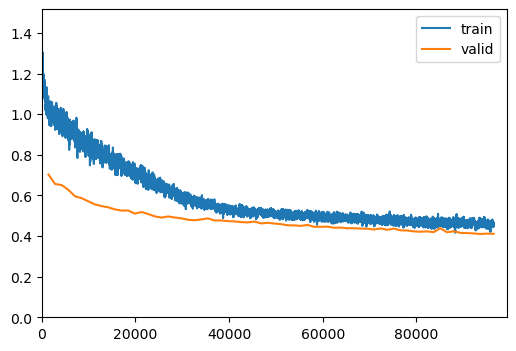

Better model found at epoch 1 with valid_loss value: 0.6564817428588867.
Better model found at epoch 2 with valid_loss value: 0.6510801911354065.
Better model found at epoch 3 with valid_loss value: 0.6274361610412598.
Better model found at epoch 4 with valid_loss value: 0.5955187678337097.
Better model found at epoch 5 with valid_loss value: 0.5865806937217712.
Better model found at epoch 6 with valid_loss value: 0.571111261844635.
Better model found at epoch 7 with valid_loss value: 0.5557690858840942.
Better model found at epoch 8 with valid_loss value: 0.5475870966911316.
Better model found at epoch 9 with valid_loss value: 0.5415809154510498.
Better model found at epoch 10 with valid_loss value: 0.5314924120903015.
Better model found at epoch 11 with valid_loss value: 0.5254009962081909.
Better model found at epoch 13 with valid_loss value: 0.5106443762779236.
Better model found at epoch 15 with valid_loss value: 0.5086254477500916.
Better model found at epoch 16 with valid_loss v

In [18]:
# Congelamos
learn_resnet.freeze()
learn_resnet.fit_one_cycle(FREEZE_EPOCHS, lrs[0], pct_start=0.99, cbs=callbacks)

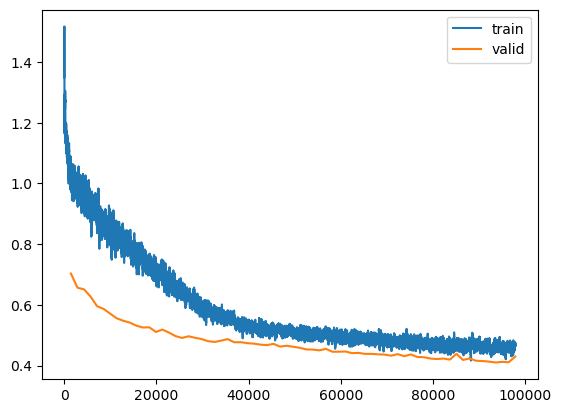

In [19]:
perdidas = learn_resnet.recorder.plot_loss(skip_start=0, with_valid=True)
plt.savefig("perdidas50_freeze_album.png")

 Fase de descongelado:
 LR: 5.482391134137288e-05


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,0.456966,0.409256,0.819667,0.807295,0.180333,0.785629,0.556404,08:35
1,0.451008,0.409288,0.820129,0.808373,0.179871,0.787784,0.557080,09:23
2,0.460160,0.420421,0.834515,0.798378,0.165485,0.735090,0.592014,08:45
3,0.449515,0.408654,0.822698,0.809921,0.177302,0.787545,0.561859,09:30
4,0.464195,0.409126,0.826706,0.809425,0.173294,0.779162,0.570302,11:38
5,0.436714,0.406999,0.823263,0.810629,0.176737,0.788503,0.562831,12:03
6,0.465888,0.403748,0.807182,0.810579,0.192818,0.816527,0.532989,12:53
7,0.464866,0.402816,0.815043,0.814015,0.184957,0.812216,0.546319,12:45
8,0.448712,0.407067,0.828504,0.810918,0.171496,0.780120,0.573719,13:13
9,0.455629,0.402980,0.828555,0.813998,0.171445,0.788503,0.572920,10:52


Better model found at epoch 0 with valid_loss value: 0.4092560410499573.


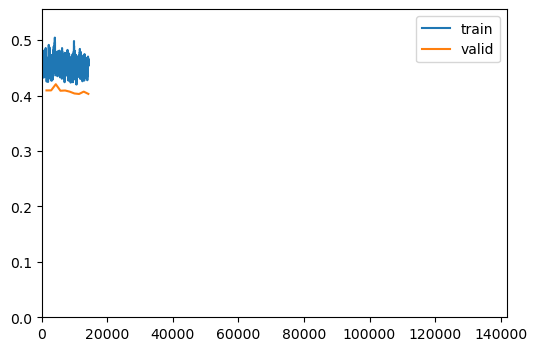

Better model found at epoch 3 with valid_loss value: 0.4086536467075348.
Better model found at epoch 5 with valid_loss value: 0.40699928998947144.
Better model found at epoch 6 with valid_loss value: 0.40374821424484253.
Better model found at epoch 7 with valid_loss value: 0.40281614661216736.
No improvement since epoch 7: early stopping


In [20]:
# Descongelamos y finalizamos entrenamiento

early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=EARLY_STOP_PATIENCE)
save_callback = SaveModelCallback(monitor='valid_loss', fname='best_model_augmented32')
callbacks = [early_stopping, save_callback, ShowGraphCallback]

print("=========================\n Fase de descongelado:")
print(f" LR: {base_lr}")

learn_resnet.unfreeze()
learn_resnet.fit_one_cycle(NUM_EPOCHS, slice(base_lr / lr_mult, base_lr), cbs=callbacks)

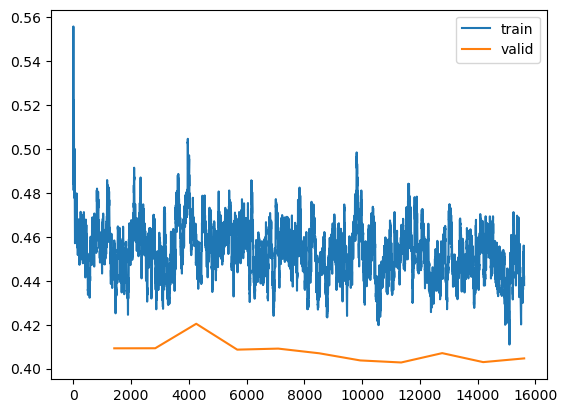

In [21]:
perdidas = learn_resnet.recorder.plot_loss(skip_start=0, with_valid=True)
plt.savefig("perdidas50_unfreeze_album.png")

In [22]:
preds, targets = learn_resnet.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación

# %%
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

# %%
print(classification_report(y_true, y_pred, target_names=train_ds.vocab))

              precision    recall  f1-score   support

      Benign       0.94      0.82      0.87     15289
   Malignant       0.55      0.81      0.65      4175

    accuracy                           0.82     19464
   macro avg       0.74      0.81      0.76     19464
weighted avg       0.86      0.82      0.83     19464



In [23]:
# Convierte el modelo a TorchScript
model = learn_resnet.model.to('cpu')
model.eval()

scripted_module = torch.jit.script(nn.Sequential(model, nn.Softmax(dim=1)))
# Export full jit version model (not compatible mobile interpreter), leave it here for comparison
scripted_module.save("skin-rn34-pc386.pt")
# Export mobile interpreter version model (compatible with mobile interpreter)
optimized_scripted_module = optimize_for_mobile(scripted_module)
optimized_scripted_module._save_for_lite_interpreter("skin-rn34android386.ptl")